-----------

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from plotly import graph_objects as go
import plotly.express as px
import plotly.io as pio
import numpy as np
import seaborn as sns
import re
import warnings
warnings.filterwarnings("ignore") 
from scipy import stats as st
import math as mth



## Шаг 1. Изучение общей информации

In [3]:
df = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


EventName         DeviceIDHash  EventTimestamp  ExpId
0         MainScreenAppear  4575588528974610257      1564029816    246
1         MainScreenAppear  7416695313311560658      1564053102    246
2  PaymentScreenSuccessful  3518123091307005509      1564054127    248
3         CartScreenAppear  3518123091307005509      1564054127    248
4  PaymentScreenSuccessful  6217807653094995999      1564055322    248

Каждому логу события соответствует наименование, ID пользователя, совершившего действия, время события и номер группы исследования

## Шаг 2. Препроцессинг

In [4]:
df.columns = ['event_name', 'user_id', 'date_time', 'group']

Заменили названия столбцов в соответствии со стилем Snake case

In [5]:
print(df.duplicated().sum())
print(df.duplicated().sum()/len(df)*100)

413
0.16917493425526162


Дубликаты составляют менее 1% от всех данных, поэтому их можно удалить

In [6]:
df = df.drop_duplicates().reset_index(drop=True)

In [7]:
df['date_time'] = pd.to_datetime(df['date_time'], unit='s')
df['date'] = df['date_time'].dt.strftime('%Y-%m-%d')

In [8]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   user_id     243713 non-null  int64         
 2   date_time   243713 non-null  datetime64[ns]
 3   group       243713 non-null  int64         
 4   date        243713 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 9.3+ MB


event_name              user_id           date_time  group  \
0         MainScreenAppear  4575588528974610257 2019-07-25 04:43:36    246   
1         MainScreenAppear  7416695313311560658 2019-07-25 11:11:42    246   
2  PaymentScreenSuccessful  3518123091307005509 2019-07-25 11:28:47    248   
3         CartScreenAppear  3518123091307005509 2019-07-25 11:28:47    248   
4  PaymentScreenSuccessful  6217807653094995999 2019-07-25 11:48:42    248   

         date  
0  2019-07-25  
1  2019-07-25  
2  2019-07-25  
3  2019-07-25  
4  2019-07-25

In [9]:
df.isnull().sum()

event_name    0
user_id       0
date_time     0
group         0
date          0
dtype: int64

Пропусков в данных не обнаружено

## Шаг 3. Изучение и проверка данных

### Сколько всего событий в логе?

In [10]:
print('всего событий:',df['event_name'].count())

всего событий: 243713


In [11]:
df['event_name'].value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

### Сколько всего пользователей в логе?

In [12]:
print('пользователей в таблице:', df['user_id'].count())

пользователей в таблице: 243713


In [13]:
print('уникальных пользователей в таблице:', df['user_id'].nunique())

уникальных пользователей в таблице: 7551


### Сколько в среднем событий приходится на пользователя?

In [14]:
print(df.groupby('user_id')['event_name'].agg('count').median()) #медианное количество событий на пользователя
print(df.groupby('user_id')['event_name'].agg('count').mean()) #среднее количество событий на пользователя

20.0
32.27559263673685


### Данными за какой период вы располагаете? Найдите максимальную и минимальную дату. Постройте гистограмму по дате и времени. Можно ли быть уверенным, что у вас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определите, с какого момента данные полные и отбросьте более старые. Данными за какой период времени вы располагаете на самом деле?

In [15]:
print('Начальный момент:',df['date_time'].min())
print('Конечный момент:',df['date_time'].max())

Начальный момент: 2019-07-25 04:43:36
Конечный момент: 2019-08-07 21:15:17


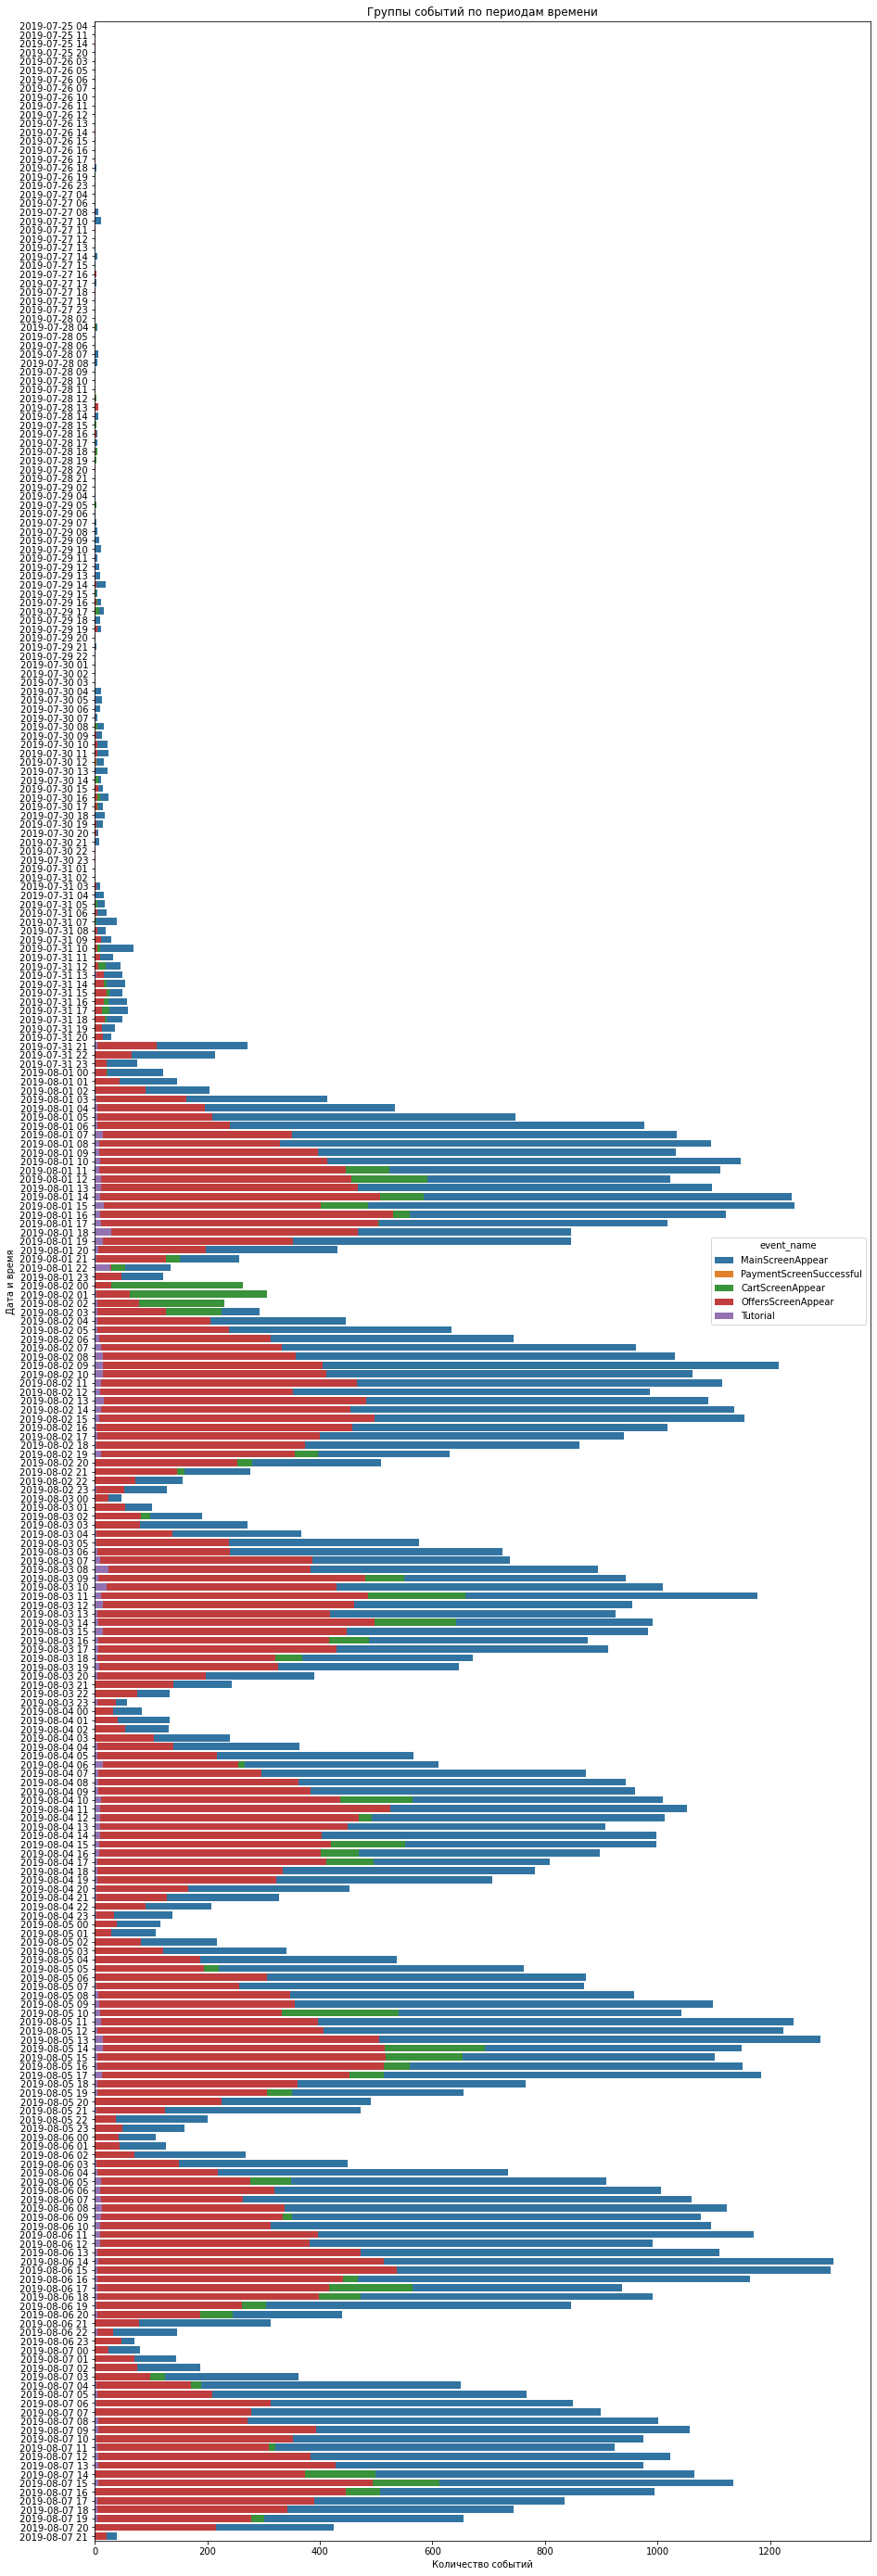

In [16]:
plt.figure(figsize=(15, 50))
ax = sns.countplot(y=df['date_time'].dt.strftime('%Y-%m-%d %H'), hue='event_name', data=df, dodge=False)
ax.set_title('Группы событий по периодам времени')
ax.set_ylabel('Дата и время')
ax.set_xlabel('Количество событий')
plt.show()

Можно заметить, что данные становятся полными, начиная с 31 июля 2019 года, 21 часа, до этого события практически отсутствуют. Отбросим данные до выделенного промежутка (с 2019-07-31 21:00 по 2019-08-07 21:00) 

In [17]:
df_new = df['2019-07-31 21:00' <= df['date_time']]

### Много ли событий и пользователей вы потеряли, отбросив старые данные?

In [18]:
print('пользователей в изначальной таблице:', df['event_name'].count())
print('всего событий после ограничения временного промежутка исследования:',df_new['event_name'].count())
print('Абсолютные потери:', df['event_name'].count() - df_new['event_name'].count())
print('Относительные потери:', 1-df_new['event_name'].count()/df['event_name'].count())

пользователей в изначальной таблице: 243713
всего событий после ограничения временного промежутка исследования: 241724
Абсолютные потери: 1989
Относительные потери: 0.0081612388342025


In [19]:
print('уникальных пользователей в изначальной таблице:', df['user_id'].nunique())
print('пользователей после ограничения временного промежутка исследования:', df_new['user_id'].nunique())
print('Абсолютные потери:', df['user_id'].nunique() - df_new['user_id'].nunique())
print('Относительные потери:', 1-df_new['user_id'].nunique()/df['user_id'].nunique())

уникальных пользователей в изначальной таблице: 7551
пользователей после ограничения временного промежутка исследования: 7538
Абсолютные потери: 13
Относительные потери: 0.0017216262746656552


В обоих случаях (для событий и пользователей) потери при ограничении временного промежутка составили менее 1%, соответственно, анализ полученных данных будет вполне достоверен, так как отражает реальную ситуацию 

### Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп.

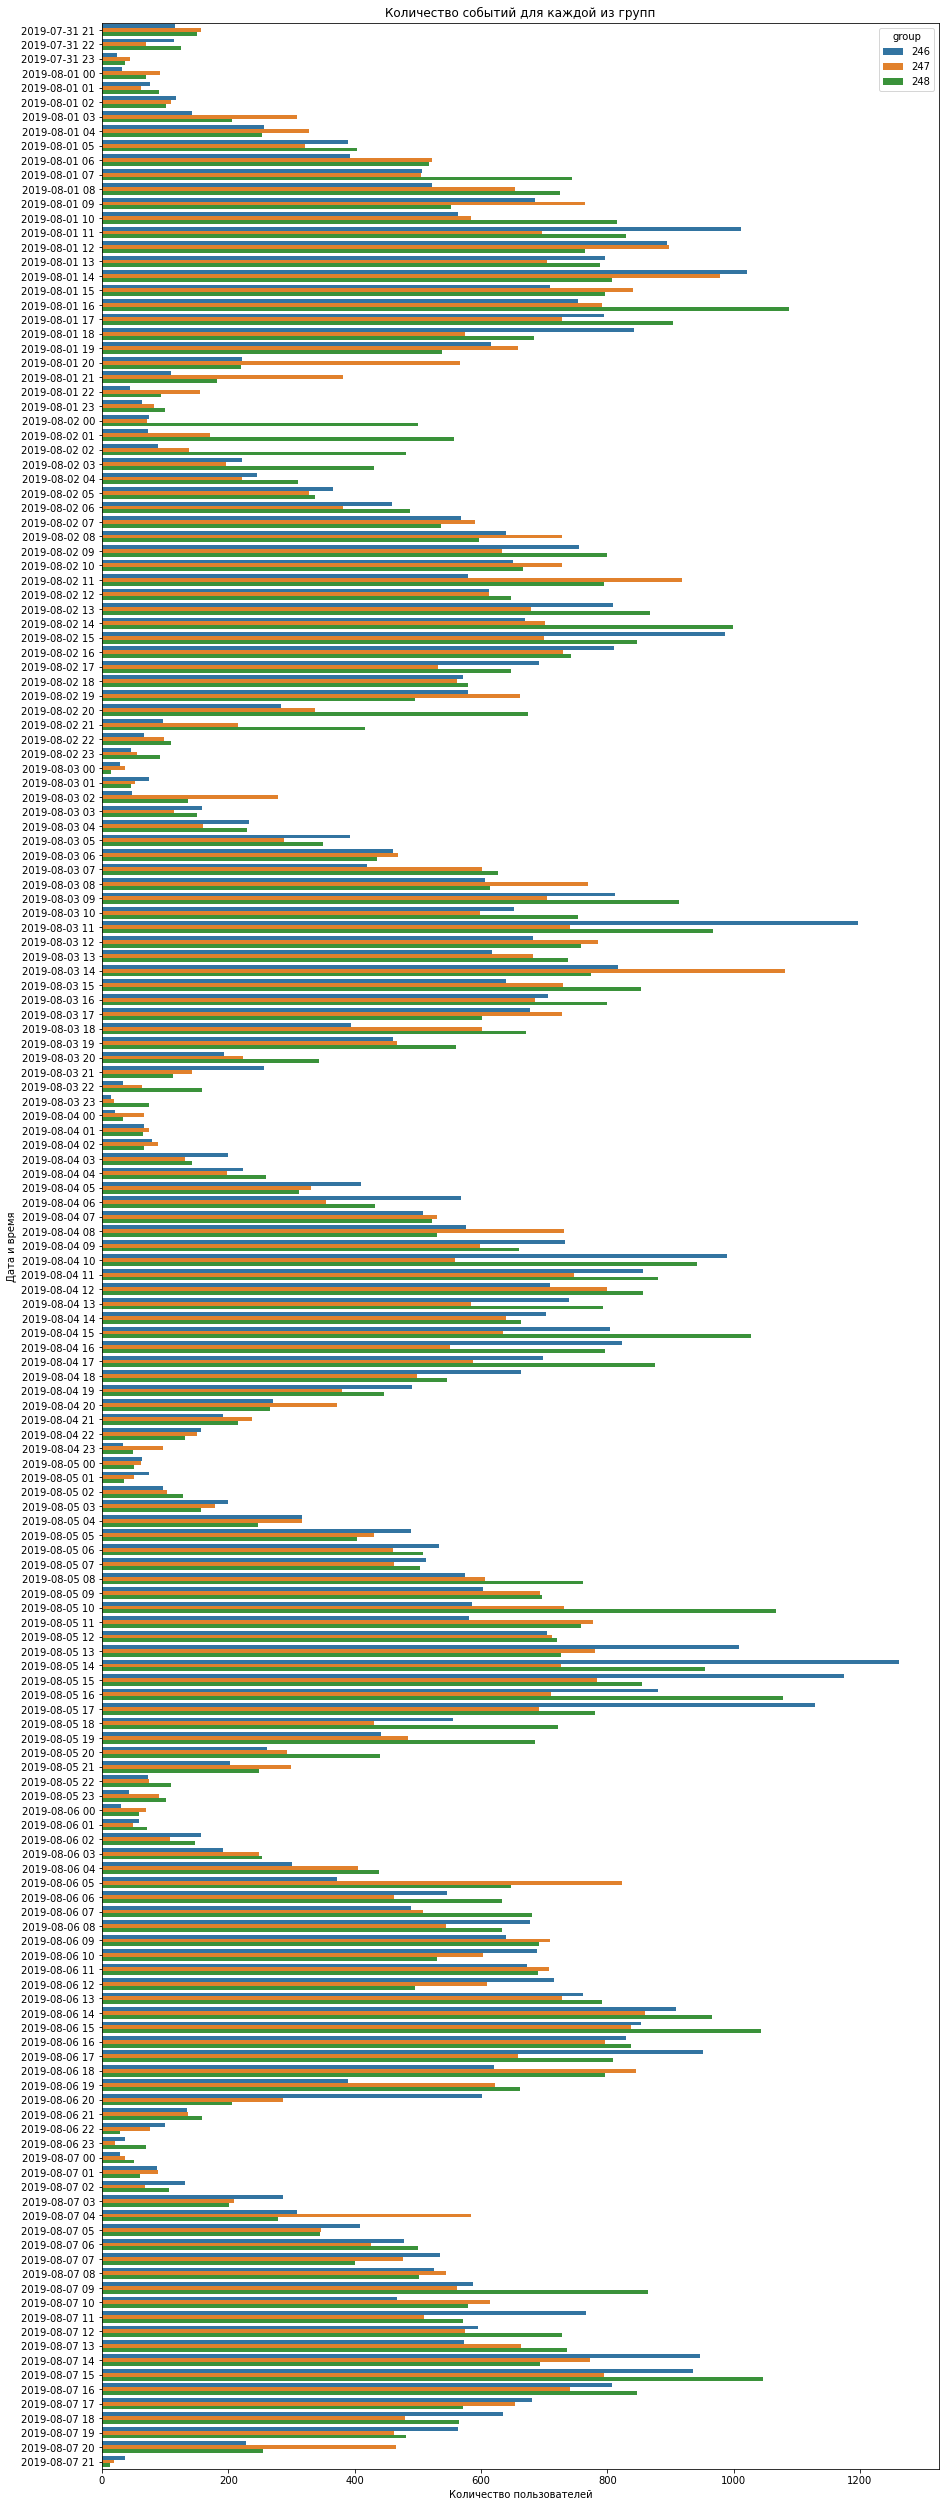

In [20]:
plt.figure(figsize=(15, 45))
ax = sns.countplot(y=df_new['date_time'].dt.strftime('%Y-%m-%d %H'),  data=df_new, hue='group')
ax.set_title('Количество событий для каждой из групп')
ax.set_ylabel('Дата и время')
ax.set_xlabel('Количество пользователей')
plt.show()

В анализе задействованы пользователи всех групп, причем распределение почти полностью равномерное

## Шаг 4. Изучите воронку событий

### Посмотрите, какие события есть в логах, как часто они встречаются. Отсортируйте события по частоте.

In [21]:
print('События в логах по частоте встречаемости:')
print(df_new['event_name'].value_counts())
print('Доли событий по частоте встречаемости:')
print(round(df_new['event_name'].value_counts()/len(df_new)*100,2))

События в логах по частоте встречаемости:
MainScreenAppear           117889
OffersScreenAppear          46531
CartScreenAppear            42343
PaymentScreenSuccessful     33951
Tutorial                     1010
Name: event_name, dtype: int64
Доли событий по частоте встречаемости:
MainScreenAppear           48.77
OffersScreenAppear         19.25
CartScreenAppear           17.52
PaymentScreenSuccessful    14.05
Tutorial                    0.42
Name: event_name, dtype: float64


Большая часть событий и почти половина от общего количества - это "Появление Главного экрана". Также большую часть событий (19.25%) составляет "Появление Экрана Предложений" (19,2%). Наименьшую долю составляют события "Руководство пользователя", менее 1%. 

### Посчитайте, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие.

In [22]:
events_users = df_new.groupby('event_name').agg({'event_name':'count', 'user_id':'nunique'}).sort_values(by='user_id', ascending=False)
events_users['users_per_event'] = (events_users['user_id'] / df_new['user_id'].nunique() * 100).round(1) 
events_users.columns = ['count_events', 'count_users', 'users_per_event']
events_users = pd.DataFrame(events_users.reset_index())
print(events_users)

                event_name  count_events  count_users  users_per_event
0         MainScreenAppear        117889         7423             98.5
1       OffersScreenAppear         46531         4597             61.0
2         CartScreenAppear         42343         3736             49.6
3  PaymentScreenSuccessful         33951         3540             47.0
4                 Tutorial          1010          843             11.2


Таким образом, самая большая часть пользователей участвовала в событии "MainScreenAppear"(Появление главного экрана) (98% от общего количества). В остальных событиях участвовали гораздо меньшие доли пользователей. Меньше всего пользователей совершали событие "Руководство пользователя" (11%)

### Предположите, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.

Предположение о структуре цепочки событий по результатам предыдущего пункта:
1. MainScreenAppear - зайти на сайт
2. OffersScreenAppear - поиск товара по каталогу
3. CartScreenAppear - добавление товара в корзину
4. PaymentScreenSuccessful - оплата товара

Так как событие "Tutorial" составляет очень малую долю как среди всех событий, так и по количеству задействованных в него пользователей, оно будет исключено из анализа

In [23]:
events_users = events_users.drop(index=4)
events_users

event_name  count_events  count_users  users_per_event
0         MainScreenAppear        117889         7423             98.5
1       OffersScreenAppear         46531         4597             61.0
2         CartScreenAppear         42343         3736             49.6
3  PaymentScreenSuccessful         33951         3540             47.0

### По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.

In [24]:
prev_users = events_users.loc[0,'count_users']
start_users = prev_users
for i in events_users.index:
    events_users.loc[i,'part_to_last'] = (events_users.loc[i,'count_users'] / prev_users * 100).round(1)
    events_users.loc[i,'part_to_first'] = (events_users.loc[i,'count_users'] / start_users * 100).round(1)
    prev_users = events_users.loc[i,'count_users']
events_users  

event_name  count_events  count_users  users_per_event  \
0         MainScreenAppear        117889         7423             98.5   
1       OffersScreenAppear         46531         4597             61.0   
2         CartScreenAppear         42343         3736             49.6   
3  PaymentScreenSuccessful         33951         3540             47.0   

   part_to_last  part_to_first  
0         100.0          100.0  
1          61.9           61.9  
2          81.3           50.3  
3          94.8           47.7

In [25]:
plt.figure(figsize=(35,14))
fig = go.Figure(go.Funnel(x = events_users['part_to_last'], y = events_users['event_name'],
                          marker = {"color": ["deepskyblue", "lightsalmon", "tan", "teal", "silver"],
    "line": { "color": ["wheat", "wheat", "blue", "wheat", "wheat"]}}))
fig.show()

<Figure size 2520x1008 with 0 Axes>

Можно заметить, что больше всего пользователей "уходят" на 2 этапе, при переходе к событию OffersScreenAppear (около 38%). Следует учесть этот результат при построении гипотез об улучшении пользовательского интерфейса, а именно первого экрана. Больше всего пользователей из этапа "добавление товара в корзину" переходят к этапу покупки (94.8%).

### Какая доля пользователей доходит от первого события до оплаты?

In [26]:
plt.figure(figsize=(35,14))
fig = go.Figure(go.Funnel(x = events_users['part_to_first'], y = events_users['event_name'],
                          marker = {"color": ["deepskyblue", "lightsalmon", "tan", "teal", "silver"],
    "line": { "color": ["wheat", "wheat", "blue", "wheat", "wheat"]}}))
fig.show();

<Figure size 2520x1008 with 0 Axes>

К этапу оплаты переходит почти половина пользователей, посетивших сайт (47%). Возможна ситуация, при которой некоторые этапы воронки были пропущены пользователями, которые в итоге оплатили товар, эту гипотезу тоже стоит проверить. 

In [27]:
funnel_users = df_new[df_new['event_name'] != 'Tutorial'].pivot_table(
        index=['user_id', 'group'], 
        columns='event_name', 
        values='date_time',
        aggfunc='min').reset_index()

step_1 = (~funnel_users['MainScreenAppear'].isna())
step_2 = step_1 & (funnel_users['OffersScreenAppear'] > funnel_users['MainScreenAppear'])
step_3 = step_2 & (funnel_users['CartScreenAppear'] > funnel_users['OffersScreenAppear'])
step_4 = step_3 & (funnel_users['PaymentScreenSuccessful'] > funnel_users['CartScreenAppear'])
n_MainScreenAppear = funnel_users[step_1].shape[0]
n_OffersScreenAppear = funnel_users[step_2].shape[0]
n_CartScreenAppear = funnel_users[step_3].shape[0]
n_PaymentScreenSuccessful = funnel_users[step_4].shape[0]

funnel_real = pd.DataFrame( columns = ['event_name', 'user_id'], data = [
    ['MainScreenAppear',n_MainScreenAppear],
    ['OffersScreenAppear',n_OffersScreenAppear],
    ['CartScreenAppear',n_CartScreenAppear],
    ['PaymentScreenSuccessful',n_PaymentScreenSuccessful]
])
fig = go.Figure(go.Funnel(y = funnel_real['event_name'], x = funnel_real['user_id'], 
                          marker = {"color": ["deepskyblue", "lightsalmon", "tan", "teal", "silver"],
    "line": { "color": ["wheat", "wheat", "blue", "wheat", "wheat"]}}, textinfo = "percent initial"))
fig.show();

Теперь мы видим, что реальная базисная доля покупателей составляет 6%, что сигнализирует о некоторых проблемах в функционале сайта. 

## Шаг 5. Изучите результаты эксперимента

### Сколько пользователей в каждой экспериментальной группе?

In [28]:
df_new.groupby('group')['user_id'].agg('nunique')

group
246    2484
247    2517
248    2537
Name: user_id, dtype: int64

In [30]:
print(df_new.groupby('user_id').agg({'group' : 'nunique'}).query('group>1').count()/len(df_new)*100) 

group    0.0
dtype: float64


Пересечений пользователей по группам не обнаружено

### Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.

In [27]:
def aab_group(gr):
    if gr==246:
        return 'A1'
    elif gr==247:
        return 'A2'
    elif gr==248:
        return 'B'

df_new['group'] = df_new['group'].apply(aab_group)
df_new

event_name              user_id           date_time group  \
1989      MainScreenAppear  7701922487875823903 2019-07-31 21:00:57    A2   
1990      MainScreenAppear  2539077412200498909 2019-07-31 21:01:45    A2   
1991    OffersScreenAppear  3286987355161301427 2019-07-31 21:02:21     B   
1992    OffersScreenAppear  3187166762535343300 2019-07-31 21:02:23    A2   
1993      MainScreenAppear  1118952406011435924 2019-07-31 21:03:25     B   
...                    ...                  ...                 ...   ...   
243708    MainScreenAppear  4599628364049201812 2019-08-07 21:12:25    A2   
243709    MainScreenAppear  5849806612437486590 2019-08-07 21:13:59    A1   
243710    MainScreenAppear  5746969938801999050 2019-08-07 21:14:43    A1   
243711    MainScreenAppear  5746969938801999050 2019-08-07 21:14:58    A1   
243712  OffersScreenAppear  5746969938801999050 2019-08-07 21:15:17    A1   

              date  
1989    2019-07-31  
1990    2019-07-31  
1991    2019-07-31  
1992    2019-07-31  
1993    2019-07-31  
...            ...  
243708  2019-08-07  
243709  2019-08-07  
243710  2019-08-07  
243711  2019-08-07  
243712  2019-08-07  

[241724 rows x 5 columns]

Напишем функцию, которая будет на вход принимать данные по группам и уровень статистической значимости и возвращать статистическую значимость различия между значениями групп:

In [28]:
events = (events_users.sort_values('count_events', ascending=False)['event_name']
         .reset_index(drop=True))
groups = ['A1','A2','B']
new_funnel = {}
for group in groups:
    new_funnel[group] =[]
    for event in events:
        new_funnel[group].append(df_new[(df_new['group'] == group) & (df_new['event_name'] == event)]['user_id'].nunique())

In [29]:
events

0           MainScreenAppear
1         OffersScreenAppear
2           CartScreenAppear
3    PaymentScreenSuccessful
Name: event_name, dtype: object

In [30]:
events = (events_users[events_users['event_name'] != 'Tutorial']
         .sort_values('count_events', ascending=False)['event_name']
         .reset_index(drop=True))
events.columns = ['event_name', 'count_users']
groups = ['A1','A2','B']
new_funnel = {}
for group in groups:
    new_funnel[group] =[]
    for event in events:
        new_funnel[group].append(df_new[(df_new['group'] == group) & (df_new['event_name'] == event)]['user_id'].nunique())

In [31]:
new_funnel = pd.DataFrame(new_funnel)
new_funnel['A/A'] = new_funnel['A1'] + new_funnel['A2']
new_funnel['event_name'] = events
for i  in new_funnel.index:
    print(new_funnel)

     A1    A2     B   A/A               event_name
0  2450  2479  2494  4929         MainScreenAppear
1  1542  1524  1531  3066       OffersScreenAppear
2  1266  1239  1231  2505         CartScreenAppear
3  1200  1158  1182  2358  PaymentScreenSuccessful
     A1    A2     B   A/A               event_name
0  2450  2479  2494  4929         MainScreenAppear
1  1542  1524  1531  3066       OffersScreenAppear
2  1266  1239  1231  2505         CartScreenAppear
3  1200  1158  1182  2358  PaymentScreenSuccessful
     A1    A2     B   A/A               event_name
0  2450  2479  2494  4929         MainScreenAppear
1  1542  1524  1531  3066       OffersScreenAppear
2  1266  1239  1231  2505         CartScreenAppear
3  1200  1158  1182  2358  PaymentScreenSuccessful
     A1    A2     B   A/A               event_name
0  2450  2479  2494  4929         MainScreenAppear
1  1542  1524  1531  3066       OffersScreenAppear
2  1266  1239  1231  2505         CartScreenAppear
3  1200  1158  1182  2358  Paym

In [32]:
count_users = {'all': df_new['user_id'].nunique(), 
           'A1': df_new[df_new['group']=='A1']['user_id'].nunique(),
           'A2': df_new[df_new['group']=='A2']['user_id'].nunique(),
           'B': df_new[df_new['group']=='B']['user_id'].nunique(),
           'A/A': df_new[(df_new['group']=='A1') | (df_new['group']=='A2')]['user_id'].nunique()}

In [34]:
new_funnel = pd.DataFrame(new_funnel)
new_funnel['A/A'] = new_funnel['A1'] + new_funnel['A2']
new_funnel['event_name'] = events
def z_value_diff(first_group, second_group, alpha):
    for i in new_funnel.index:
        alpha = alpha
        p1 = new_funnel[first_group][i] / count_users[first_group]
        p2 = new_funnel[second_group][i] / count_users[second_group]
        p_combined = ((new_funnel[first_group][i] + new_funnel[second_group][i]) / 
                      (count_users[first_group] + count_users[second_group]))
        difference = p1 - p2
        # статистика стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * 
                                        (1/count_users[first_group] + 1/count_users[second_group]))
        distr = st.norm(0, 1) 
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        print('{} p-значение: {}'.format(new_funnel['event_name'][i], p_value))
        if (p_value < alpha):
            print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
        print('')

In [35]:
z_value_diff('A1','A2',0.05)

MainScreenAppear p-значение: 0.6756217702005545
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.26698769175859516
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.2182812140633792
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.10298394982948822
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Таким образом, выделенные контрольные группы имеют схожие ключевые метрики

In [36]:
z_value_diff('A1','B',0.05)

MainScreenAppear p-значение: 0.34705881021236484
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.08328412977507749
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.22269358994682742
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [37]:
z_value_diff('A2','B',0.05)

MainScreenAppear p-значение: 0.6001661582453706
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.8835956656016957
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.6169517476996997
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.6775413642906454
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [38]:
z_value_diff('A/A','B',0.05)

MainScreenAppear p-значение: 0.39298914928006035
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.418998284007599
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.19819340844527744
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.6452057673098244
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [39]:
z_value_diff('A1','A2',0.1)

MainScreenAppear p-значение: 0.6756217702005545
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.26698769175859516
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.2182812140633792
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.10298394982948822
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [40]:
z_value_diff('A1','B',0.1)

MainScreenAppear p-значение: 0.34705881021236484
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.08328412977507749
Отвергаем нулевую гипотезу: между долями есть значимая разница

PaymentScreenSuccessful p-значение: 0.22269358994682742
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [41]:
z_value_diff('A2','B',0.1)

MainScreenAppear p-значение: 0.6001661582453706
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.8835956656016957
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.6169517476996997
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.6775413642906454
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [42]:
z_value_diff('A/A','B',0.1)

MainScreenAppear p-значение: 0.39298914928006035
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.418998284007599
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.19819340844527744
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.6452057673098244
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Как можно заметить, статистически значимых различий не было выявлено ни при одном сравнении и уровне стат. значимости. Единственный раз было выявлено различие между первой контрольной группой и экспериментальной в событии CartScreenAppear в пользу изначальной версии, но при стат. значимости в 10% результаты могут варьироваться, также это лишь одно событие из рассматриваемых четырех, поэтому не будем в дальнейшем учитывать это различие. 

## Выводы

Промежуточные выводы:
- Большая часть событий и почти половина от общего количества - это "Появление Главного экрана". Также большую часть событий (19.25%) составляет "Появление Экрана Предложений" (19,2%). Наименьшую долю составляют события "Руководство пользователя", менее 1%.
- Самая большая часть пользователей участвовала в событии "MainScreenAppear"(Появление главного экрана) (98% от общего количества). В остальных событиях участвовали гораздо меньшие доли пользователей. Меньше всего пользователей совершали событие "Руководство пользователя" (11%)
- Больше всего пользователей "уходят" на 2 этапе, при переходе к событию OffersScreenAppear (около 38%). Следует учесть этот результат при построении гипотез об улучшении пользовательского интерфейса, а именно первого экрана. Больше всего пользователей из этапа "добавление товара в корзину" переходят к этапу покупки (94.8%)
- Реальная базисная доля тех, кто доходит до этапа оплаты, составляет 6%, что сигнализирует о некоторых проблемах в функционале сайта.
- Статистически значимых различий не было выявлено ни при одном сравнении контрольных и экспериментальных групп и уровне стат. значимости. Единственный раз было выявлено различие между первой контрольной группой и экспериментальной в событии CartScreenAppear в пользу изначальной версии, но при стат. значимости в 10% результаты могут варьироваться, также это лишь одно событие из рассматриваемых четырех, поэтому не будем в дальнейшем учитывать это различие

Общий вывод:
- Изменение шрифта значимым образом не повлияет на поведение пользователей, таким образом, если это изменение не является технической необходимостью, его не стоит вносить.